   It is a tutorial of training a neural network model to predict molecular property like homo, lumo, heat capacity, etc.
   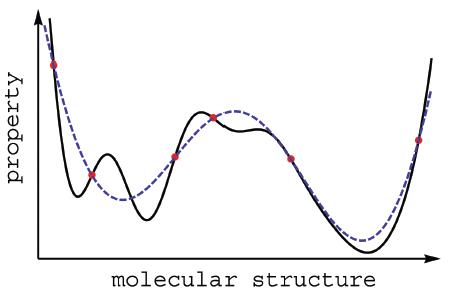

Rupp et al proposed Coulomb matrix to represent molecular. Stuctures and compostion are both encoded into Coulomb matrix.
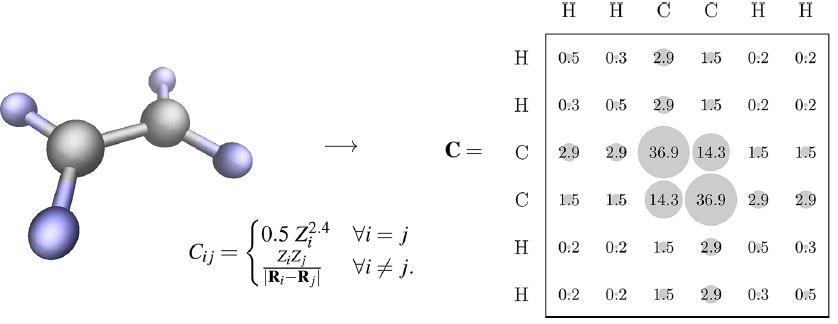

The sorted eigenvalues vector of the i-th molecular's Coulomb matrix is xi ('molecular structure'), the DFT AE is y_i ('property'). Our task is to build a model which predicts AE close to the DFT ones. This is a supervised machine learning. 
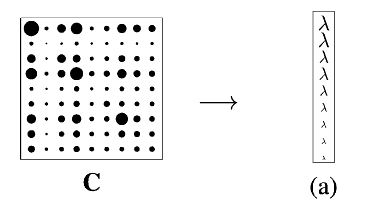

Now we choose neural network model to 'learn' the relationship between molecular's property and structure.
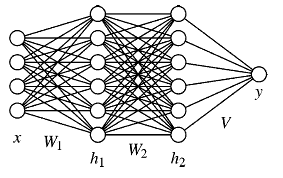

Input layer: the sorted eigenvalues of Coulomb matrix (x)
Hiden layers: f_i(Wx+b) 
Output layer: the predicted property (y_p)

In the file 'molecular.mat', data of 109 moleculars is storaged for the training/test of neural network model. The original data was calculated by Gaussian and  storaged in a MySQL database. In this molecular set, the number of atoms in every molecular is no more than 18.   

In [74]:
import tensorflow as tf;
import numpy as np;
import scipy,scipy.io,os,random;

In [75]:
directory = "D:/tensorflow_work/retrieve_from_mysql";
os.chdir(directory)

In [76]:
%run ./mysql.py
# Retrieve data from MySQL database created by jianghui.

In [77]:
mol_data = scipy.io.loadmat('molecular.mat');
type(mol_data)
mol_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'id', 'xyzs0', 'atomnum', 'elementid', 'colomb_matrix', 'colomb_matrix_eigenvalues', 'r2', 'cv', 'u0', 'homo', 'lumo'])

In [78]:
# Split the total molecules set into training and test sets.
# return properties (containing in list p) and colomb matrixs, spectrums of colomb matrixs
def split_training_test(mol_data,p,
                       N_total    = len(mol_data['id']),
                       N_training = round(0.67*len(mol_data['id'])-1),
                       N_test     = len(mol_data['id'])-round(0.67*len(mol_data['id'])-1)):

    index_entire = list(range(N_total))
    random.shuffle(index_entire)
    
    index_training  = index_entire[0:N_training]
    index_test      = index_entire[N_training:N_test+N_training]
    
    num_p = len(p)
    properties_training = np.zeros([N_training,num_p])
    properties_test     = np.zeros([N_test,num_p])

    for i in list(range(num_p)):
        properties_training[:,i]  = np.reshape(mol_data[p[i]][index_training],[N_training,])
        properties_test[:,i]      = np.reshape(mol_data[p[i]][index_test],[N_test,])

    cm_eigenvalue_training     = mol_data['colomb_matrix_eigenvalues'][index_training]
    cm_eigenvalue_test         = mol_data['colomb_matrix_eigenvalues'][index_test]
    
    return properties_training,properties_test,cm_eigenvalue_training,cm_eigenvalue_test,index_training,index_test 
# return the properties to be trained and test, colomb matrices' eigenvalues as the input data of training/test,
# and the index of molecules in training/test set.

In [79]:
p = ['u0'];
p_unit =['kcal/mol'];
p_limit = [1.00];
# choose the property that will be trained and predicted
# the corresponding unit
# the precision limit that is good enough 

In [80]:
properties_training,properties_test,cm_eigenvalue_training,cm_eigenvalue_test,index_training,index_test = split_training_test(mol_data,p,109,70)

In [81]:
print ("Total set size: %i,Training set size: %i,Test set size: %i."%(len(index_test+index_training),
                                                                    len(index_training),
                                                                    len(index_test)))

Total set size: 107,Training set size: 70,Test set size: 37.


In [82]:
M     = 300    # M, N nodes in the 1st, 2nd layer specifically.
N     = 120

X  = tf.placeholder(tf.float32, [None, 18])
Y_ = tf.placeholder(tf.float32, [None, 1])
# X is a placeholder that will contain batch groups of input data,
# like eigenvalues of a colomb matrix.
# Y_ is a placeholder that will contain batch groups of label data

In [83]:
W1 = tf.Variable(tf.zeros([18,M]))
B1 = tf.Variable(tf.zeros([M]))

W2 = tf.Variable(tf.truncated_normal([M, N],stddev=0.2))
B2 = tf.Variable(tf.zeros([N]))

W3 = tf.Variable(tf.truncated_normal([N, 1], stddev=0.1))
B3 = tf.Variable(tf.zeros([1]))

In [84]:
h1 = tf.nn.sigmoid(tf.matmul(X, W1) + B1)
h2 = tf.matmul(h1, W2) + B2
Y  = tf.matmul(h2, W3) + B3
# Y is the output.

In [85]:
loss      = tf.reduce_sum(tf.squared_difference(Y,Y_))   #loss function
mae       = tf.reduce_mean(tf.abs(Y-Y_)) 

In [86]:
optimizer  = tf.train.AdamOptimizer(0.004) 
train      = optimizer.minimize(loss)
init       = tf.global_variables_initializer()

In [87]:
sess1    =  tf.Session() 
sess1.run(init)

In [88]:
total_steps=6000
batch =  5

for  step in range(0,total_steps+1):    
   
    # In every iteration step, the index_training is randomly resorted   
    random.shuffle(index_training)    
    
    # The top batch samples are chosen and fed into neural network
    batch_X   =   mol_data['colomb_matrix_eigenvalues'][index_training[0:batch]]
    batch_X   =   batch_X.astype(np.float32)
    batch_Y_  =   mol_data[p[0]][index_training[0:batch]]
    batch_Y_  =   batch_Y_.astype(np.float32)


    sess1.run(train,feed_dict={X:batch_X, Y_:batch_Y_})
    MAE  =  sess1.run(mae,feed_dict={X:batch_X,Y_:batch_Y_})

    if step%1000 == 0:
        print  ("step %i, MAE = %8.5f (kcal/mol)"%(step,MAE))

print ("Training done.Training error (MAE) = %8.5f(kcal/mol)"%(MAE))

step 0, MAE = 230.82950 (kcal/mol)
step 1000, MAE = 12.02578 (kcal/mol)
step 2000, MAE = 10.84926 (kcal/mol)
step 3000, MAE =  5.53502 (kcal/mol)
step 4000, MAE =  5.29247 (kcal/mol)
step 5000, MAE =  5.79048 (kcal/mol)
step 6000, MAE =  4.50555 (kcal/mol)
Training done.Training error (MAE) =  4.50555(kcal/mol)


In [89]:
print ("Test starts.%d moleculars in the test set."%(len(index_test)))

test_X   =   mol_data['colomb_matrix_eigenvalues'][index_test]
test_X   =   test_X.astype(np.float32)
test_Y_  =   mol_data[p[0]][index_test]
test_Y_  =   test_Y_.astype(np.float32)

TEST_MAE = sess1.run(mae,feed_dict={X:test_X,Y_:test_Y_})

print ("Testing error(MAE):%5.2f(kcal/mol)"%(TEST_MAE))
print ("The ideal precision is less than %5.2f(kcal/mol) "%(p_limit[0]))
print ("Test done.")

Test starts.37 moleculars in the test set.
Testing error(MAE): 9.16(kcal/mol)
The ideal precision is less than  1.00(kcal/mol) 
Test done.
